<h3> Overall Takeaways </h3>

Many different approaches to stock prediction, using a variety of types of datasets. Unfortunately, some of the approaches utilize concepts that will be covered later in the course, so for these approaches, I will summarize my learnings for the future, when I'm able to implement these approaches.

<ol>
  <li> Stock prediction using traditional ML approaches and quantitative data - Stefan Jansen </li>
    Many different approaches outlined in his textbook, however, I will start with RNN on S&P 500 data to predict the price. <br />
  https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/19_recurrent_neural_nets/01_univariate_time_series_regression.ipynb
  <li> Stock prediction using financial news and technical + fundamental data - Astock dataset </li>
  While I do not feel like I have the tools to pursue this approach at the moment, I believe that my final project should include at least one NLP approach, and this is one such example. I will summarize (to the best of my abilities) the approach and the results in this PapersWithCode project on using financial news.
  <li> Twitter based NLP? </li>
  https://github.com/yumoxu/stocknet-dataset
</ol>


In [3]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [5]:
sns.set_style('whitegrid')
np.random.seed(42)

In [6]:
results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

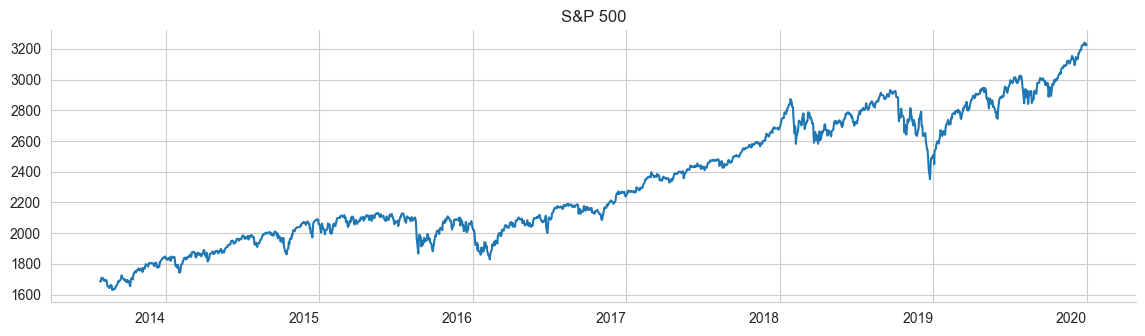

In [28]:
sp500 = web.DataReader('SP500', 'fred', start='2010', end='2020').dropna()
ax = sp500.plot(title='S&P 500',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

In [29]:
scaler = MinMaxScaler()

sp500_scaled = pd.Series(scaler.fit_transform(sp500).squeeze(), 
                         index=sp500.index)
sp500_scaled.describe()

def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

window_size = 63

X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
DATE,,,,,,,,,,,,,,,,,,,,,
2013-10-25,0.034078,0.034469,0.034327,0.047461,0.049200,0.047629,0.041558,0.037545,0.041627,0.037862,...,0.045181,0.049492,0.041987,0.056575,0.063788,0.070840,0.070940,0.077159,0.072008,0.075543
2013-10-28,0.034469,0.034327,0.047461,0.049200,0.047629,0.041558,0.037545,0.041627,0.037862,0.036650,...,0.049492,0.041987,0.056575,0.063788,0.070840,0.070940,0.077159,0.072008,0.075543,0.080327
2013-10-29,0.034327,0.047461,0.049200,0.047629,0.041558,0.037545,0.041627,0.037862,0.036650,0.039564,...,0.041987,0.056575,0.063788,0.070840,0.070940,0.077159,0.072008,0.075543,0.080327,0.081781
2013-10-30,0.047461,0.049200,0.047629,0.041558,0.037545,0.041627,0.037862,0.036650,0.039564,0.034115,...,0.056575,0.063788,0.070840,0.070940,0.077159,0.072008,0.075543,0.080327,0.081781,0.087895
2013-10-31,0.049200,0.047629,0.041558,0.037545,0.041627,0.037862,0.036650,0.039564,0.034115,0.019161,...,0.063788,0.070840,0.070940,0.077159,0.072008,0.075543,0.080327,0.081781,0.087895,0.082527


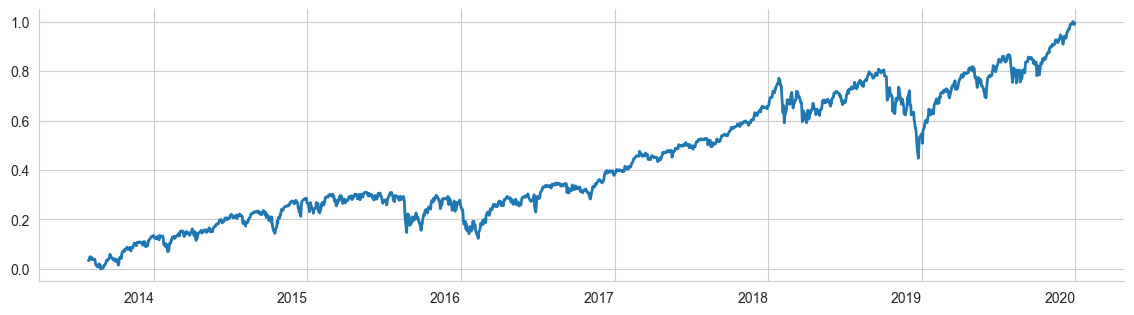

In [30]:
ax = sp500_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [45]:
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

X_train = X[:'2018'].values.reshape(-1, window_size, 1)
y_train = y[:'2018']

# keep the last year for testing
X_test = X['2019':].values.reshape(-1, window_size, 1)
y_test = y['2019':]

n_obs, window_size, n_features = X_train.shape

y_train.shape

(1304,)

In [47]:
rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
optimizer = keras.optimizers.RMSprop(lr=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

rnn.compile(loss='mean_squared_error', 
            optimizer=optimizer)

rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)

ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.RMSprop.